# METRLADatasetLoader-Tutorial

SEOYEON CHOI  
2023-04-06

> METRLADatasetLoader

In [5]:
import torch
from IPython.display import clear_output
pt_version = torch.__version__
print(pt_version)

1.10.1

In [8]:
import numpy as np
from torch_geometric_temporal.dataset import METRLADatasetLoader
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

loader = METRLADatasetLoader()
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)

#print("Dataset type:  ", dataset)
#print("Number of samples / sequences: ",  len(set(dataset)))

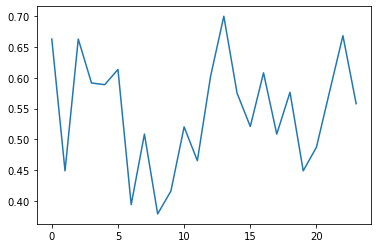

In [10]:
import seaborn as sns
# Visualize traffic over time
sensor_number = 1
hours = 24
sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:hours]]
sns.lineplot(data=sensor_labels)

In [12]:
from torch_geometric_temporal.signal import temporal_signal_split
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

#print("Number of train buckets: ", len(set(train_dataset)))
#print("Number of test buckets: ", len(set(test_dataset)))

In [13]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features, 
                           out_channels=32, 
                           periods=periods)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

TemporalGNN(node_features=2, periods=12)

In [14]:
# GPU support
device = torch.device('cpu') # cuda
subset = 2000

# Create model and optimizers
model = TemporalGNN(node_features=2, periods=12).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

print("Running training...")
for epoch in range(10): 
    loss = 0
    step = 0
    for snapshot in train_dataset:
        snapshot = snapshot.to(device)
        # Get model predictions
        y_hat = model(snapshot.x, snapshot.edge_index)
        # Mean squared error
        loss = loss + torch.mean((y_hat-snapshot.y)**2) 
        step += 1
        if step > subset:
          break

    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print("Epoch {} train MSE: {:.4f}".format(epoch, loss.item()))

Running training...
Epoch 0 train MSE: 0.7596
Epoch 1 train MSE: 0.7398
Epoch 2 train MSE: 0.7205
Epoch 3 train MSE: 0.6996
Epoch 4 train MSE: 0.6759
Epoch 5 train MSE: 0.6495
Epoch 6 train MSE: 0.6221
Epoch 7 train MSE: 0.5963
Epoch 8 train MSE: 0.5743
Epoch 9 train MSE: 0.5573

In [15]:
model.eval()
loss = 0
step = 0
horizon = 288

# Store for analysis
predictions = []
labels = []

for snapshot in test_dataset:
    snapshot = snapshot.to(device)
    # Get predictions
    y_hat = model(snapshot.x, snapshot.edge_index)
    # Mean squared error
    loss = loss + torch.mean((y_hat-snapshot.y)**2)
    # Store for analysis below
    labels.append(snapshot.y)
    predictions.append(y_hat)
    step += 1
    if step > horizon:
          break

loss = loss / (step+1)
loss = loss.item()
print("Test MSE: {:.4f}".format(loss))

Test MSE: 0.6738